In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using Plots
using Test
include("car.jl");

 Activating environment at `~/Classes/OptimalControl/hw2/Project.toml`
 Activating environment at `~/Classes/OptimalControl/hw2/Project.toml`


# Question 3: TVLQR
In this problem we'll use time-varying LQR (TVLQR) to track a reference trajectory for a simplified model of a car. 

## The Model
In this problem we'll be using the standard kinematic "bicycle" model for a car. As a kinematic model, we don't consider the effects of things like tire forces, friction, or aerodynamics forces. The bicycle model combines the tires on each axle into a single tire, and uses simple trigonometric relationships to describe the motion of car. While deriving these equations is good practice, we'll just state them here:

$$ 
x = \begin{bmatrix} p_x \\ p_y \\ \theta \\ \delta \end{bmatrix}, \quad
u = \begin{bmatrix} v \\ \phi \end{bmatrix}, \quad
\dot{x} = \begin{bmatrix} v \cos{(\theta + \beta)} \\ v \sin{(\theta + \beta)} \\ \frac{v \cos{\beta} \tan{\delta}}{L} \\ \phi \end{bmatrix}
$$

where $\theta$ is the yaw angle, $\delta$ is the steering angle, $v$ is the forward velocity, $\phi$ is the steering angle rate, $L$ is the distance between the wheels, and $\beta = \text{atan2}(\delta l_r, L)$ is the side-slip angle. Here we have defined the x,y position `(p_x,p_y)` to be relative to the center of mass of the vehicle, located a distance `l_r` from the rear wheel.

In this problem, we use the `RobotDynamics.jl` package to define the model. This package allows some convenient methods to evaluate the discrete dynamics and both the continuous or discrete-time Jacobians automatically using either automatic differentiation or finite differencing. See the code block below for some simple examples of using the API.

In [2]:
# Define the model
model = BicycleModel()

# get the number of states and controls
n = state_dim(model)
m = control_dim(model)
n,m = size(model)  # alternate method

# Evaluate the continuous and discrete dynamics
x0 = SA[0,0,0,0]
u0 = SA[0,0]
t0 = 0.0
dt = 0.1
dynamics(model, x0, u0)
discrete_dynamics(RK4, model, x0, u0, t0, dt)  # use rk4 for integration

# Evaluate the continuous and discrete Jacobians
z0 = KnotPoint(x0,u0,dt,t0)   # create a `KnotPoint` type that stores everything together
∇f = RobotDynamics.DynamicsJacobian(model)
jacobian!(∇f, model, z0)
discrete_jacobian!(RK4, ∇f, model, z0)

# Extract pieces of the Jacobian
A = ∇f.A
B = ∇f.B;

## The Reference Trajectory
In this problem we'll be tracking a reference trajectory generated via trajectory optimization. The code below loads the reference trajectory, plots it using `Plots.jl` (and some custom plotting recipes in `RobotDynamics`) and visualizes it using MeshCat.

In [3]:
# Load trajectories
traj = load(TRAJFILE)
Xref,Uref,tref = traj["X"], traj["U"], traj["times"];

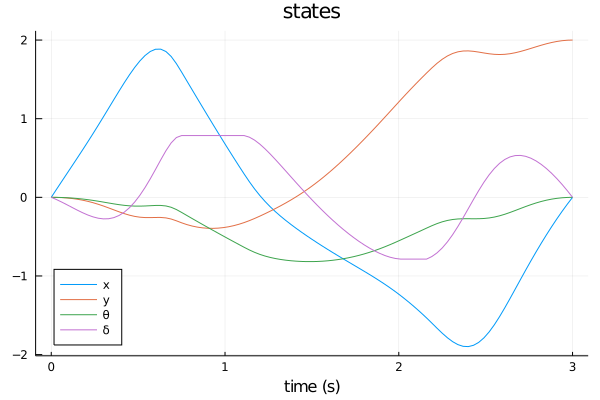

In [4]:
# Plot the states
plot(tref, Xref, inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")

# TIP: Use the `inds` keyword to plot a subset of the states, e.g. `inds=1:2` to only plot the x,y positions

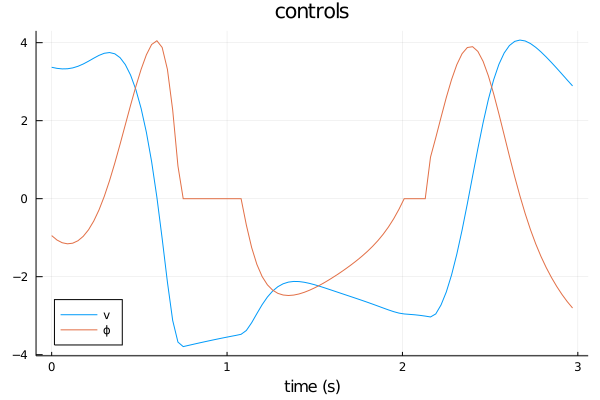

In [5]:
# Plots the controls
plot(tref[1:end-1], Uref, labels=["v" "ϕ"], legend=:bottomleft, title="controls", xlabel="time (s)")

In [6]:
# Visualize in MeshCat
vis = initialize_visualizer(model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/brian/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("chassis" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x6d, 0x2f, 0x63, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("body" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x73, 0x73, 0x69, 0x73, 0x2f, 0x62, 0x6f, 0x64, 0x79], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x73, 0x69, 0x73, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))),"front" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x66, 0x72, 0x6f, 0x6e, 0x74], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x6e, 0x74, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [7]:
# Send the trajectory to the visualizer
visualize!(vis, model, tref[end], Xref)

## Part (a): Implement TVLQR
Using the types provided below, implement the method to calculate the feedback gains `K` to track the provided trajectory

In [8]:
# TASK: Implement the following methods
#       calc_gains!
#       get_control
"""
    TVLQR{L,T}

A type that contains all the information needed to evaluate a time-varying LQR 
control policy tracking a trajectory specified by `X`, `U`, and `times`.

# Constructor
    TVLQR(model, X, U, times, Q, R, Qf)

where `model` is a `RobotDynamics.AbstractModel`, `X` and `U` are vectors of the reference
states and controls at times `times`. `Q`, `R` and `Qf` are the cost matrices for TVLQR.

# Methods
The following methods are defined on `TVLQR`:

    get_k(ctrl)
    linearize!(ctrl)
    calc_gains!(ctrl)
    get_control(ctrl, x, t)
"""
struct TVLQR{L,T}
    model::L                     # dynamics model
    X::Vector{Vector{T}}         # state reference trajectory (n,)
    U::Vector{Vector{T}}         # control reference trajectory (m,)
    times::Vector{T}             # times for each point in the trajectory (N,)
    Q::Diagonal{T,Vector{T}}     # state cost matrix for TVLQR (n,n)
    R::Diagonal{T,Vector{T}}     # control cost matrix for TVLQR (m,m)
    Qf::Matrix{T}                # terminal state cost matrix for TVLQR (n,n)
    A::Vector{Matrix{T}}         # discrete state Jacobian for each knot point (n,n)
    B::Vector{Matrix{T}}         # discrete control Jacobian for each knot point (n,m)
    K::Vector{Matrix{T}}         # feedback gain matrices (m,n)
    P::Vector{Matrix{T}}         # cost-to-go (n,n)
end
function TVLQR(model::L, X, U, times::AbstractVector, Q::AbstractMatrix, R::AbstractMatrix, Qf::AbstractMatrix) where L <: AbstractModel
    T = promote_type(eltype(X[1]), eltype(X[2]))
    n,m = size(model)
    N = length(times)
    @assert length(X[1]) == n
    @assert length(U[1]) == m
    @assert length(X) == N 
    @assert N-1 <= length(U) <= N
    A = [zeros(T,n,n) for k = 1:N-1]
    B = [zeros(T,n,m) for k = 1:N-1]
    K = [zeros(T,m,n) for k = 1:N-1]
    P = [zeros(T,n,n) for k = 1:N]
    TVLQR(model, Vector{T}.(X), Vector{T}.(U), Vector{T}(times), 
        Diagonal{T}(diag(Q)), Diagonal{T}(diag(R)), Matrix{T}(Qf),
        A, B, K, P
    )
end

"""
    get_k(ctrl, t)

Get the time index corresponding to time `t`. 
Useful for implementing zero-order hold control.
Uses binary search to find the time index.
"""
get_k(controller::TVLQR, t) = searchsortedlast(controller.times, t)

"""
    linearize!(ctrl::TVLQR)

Linearize the discretized model about the reference trajectory, storing the result in 
`A` and `B`.
"""
function linearize!(ctrl::TVLQR)
    model = ctrl.model
    N = length(ctrl.X)
    ∇f = RobotDynamics.DynamicsJacobian(model)
    X,U = ctrl.X, ctrl.U
    
    # loop over all the time steps in the reference trajectory
    for k = 1:N-1
        # some boilerplate code...
        dt = ctrl.times[k+1] - ctrl.times[k]
        z = KnotPoint(X[k], U[k], dt, ctrl.times[k])
        
        # evaluate the discrete jacobian at the current time step
        discrete_jacobian!(RK4, ∇f, model, z)
        
        # store the pieces in the controller
        ctrl.A[k] .= ∇f.A
        ctrl.B[k] .= ∇f.B
    end
end

"""
    calc_gains!(ctrl::TVLQR)

Calculate the locally-optimal feedback gains `K` about the current trajectory, 
using the linearized dynamics in `A` and `B`. Should use a Riccati recursion.

**NOTE**: `linearize!(ctrl)` must be called before calling this function!
"""
function calc_gains!(ctrl::TVLQR)
    # Extract some variables
    N = length(ctrl.X)
    A,B = ctrl.A, ctrl.B
    Q,R = ctrl.Q, ctrl.R
    P = ctrl.P
    K = ctrl.K
    
    # TODO: Implement Riccati recursion for TVLQR
    #       After this function, all the matrices in ctrl.K and ctrl.P should be updated
    P[end] .= ctrl.Qf
    for k = reverse(1:N-1) 
        K[k] .= (R + B[k]'P[k+1]*B[k])\(B[k]'P[k+1]*A[k])
        P[k] .= Q + A[k]'P[k+1]*A[k] - A[k]'P[k+1]*B[k]*K[k]
    end
    
    # no need to return anything, since the result is stored in TVLQR type
    return nothing
end

"""
    get_control(ctrl::TVLQR, x, t)

Evaluate the TVLQR feedback policy at state `x` and time `t`, returning the control 
to be executed by the system.
"""
function get_control(ctrl::TVLQR, x, t)
    # TODO: implement this function
    #       should return a vector of size (m,), where m is the number of controls
    k = get_k(ctrl, t)
    return ctrl.U[k] - ctrl.K[k]*(x - ctrl.X[k])
end

get_control

In [12]:
# TASK: verify the stability of your controller

# LQR Cost weights
Q = Diagonal([1,1,1e-2,1e-2])
R = Diagonal([1e-1,1e-1])
Qf = Diagonal([1,1,1,1.])*10

# Build controller
ctrl = TVLQR(model, Xref, Uref, tref, Q, R, Qf)

# Linearize the model about the trajectory
linearize!(ctrl)

# Calculate the gains using Riccati recursion
calc_gains!(ctrl)

Test Passed

## Part (b): Simulate the system
We'll now simulate our system using our controller, and analyze how well it tracks the reference trajectory under perturbations to the controls and the initial conditions.

In [13]:
"""
    simulate(model, x0, ctrl; [kwargs...])

Simulate `model` starting from `x0` using the `get_control(ctrl, x, t)` method to get the 
closed-loop feedback command.

# Keyword Arguments
* `tf`: final time
* `dt`: simulation time step
* `ν`: standard deviation of the white noise on the controls
* `w` standard deviation of the white noise on the steering angle
"""
function simulate(model::BicycleModel, x0, ctrl; tf=ctrl.times[end], dt=1e-2, ν=0.0, w=0.00)
    n,m = size(model)
    times = range(0, tf, step=dt)
    N = length(times)
    X = [@SVector zeros(n) for k = 1:N] 
    U = [@SVector zeros(m) for k = 1:N-1]
    X[1] = x0

    for k = 1:N-1
        U[k] = get_control(ctrl, X[k], times[k]) + SA[randn(), randn()]*ν
        X[k+1] = discrete_dynamics(RK4, model, X[k], U[k], times[k], dt) + SA[0,0,0,randn()*w]
    end
    return X,U,times
end

"""
    sse(Xref, tref, X, t)

Evaluate the normalized sum-squared error (SSE) of two trajectories of different lengths.
This assumes `length(Xref)` < `length(X)` and that `tref[2]` is a multiple of `t[2]`, 
and that both time vectors have a constant step length.
"""
function sse(Xref,tref,X,t)
    @assert length(tref) < length(t)
    step = tref[2] / t[2]
    if abs(step - round(step)) < 1e-6
        step = Int(round(step))
    end
    inds = 1:step:length(time)
    @assert norm(tref[1:length(inds)] - t[inds]) < 1e-10
    sum(norm.(X[inds] - Xref[1:length(inds)]).^2) / length(inds)
end

sse

In [10]:
# display a new visualizer pane
# TIP: you can also use `open(vis)` to open the visualizer in a tab in your browser (useful if you have multiple monitors)
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("chassis" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x6d, 0x2f, 0x63, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("body" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x73, 0x73, 0x69, 0x73, 0x2f, 0x62, 0x6f, 0x64, 0x79], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x73, 0x69, 0x73, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))),"front" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x66, 0x72, 0x6f, 0x6e, 0x74], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x6e, 0x74, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))))))), Set(Any[WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [20]:
# Simulate the system and compute the errors

# try changing both of these inputs to the simulation!
ν = 0.0            # std of control noise
xinit = [0,0,0,0]  # initial condition
X,U,time = simulate(model, xinit, ctrl, ν=ν)

# compute the errors
err_term = norm(X[end] - Xref[end])
err = sse(Xref,tref,X,time)
@show err_term
@show err

# send trajectory to the visualizer
visualize!(vis, model, time[end], X)

err_term = 0.13952131983784571
err = 0.019368668319400425


Let's look at how robust it is to white noise in the input channels, velocity and the steering angle rate. Try changing the standard deviation of the control noise and see how it affects the performance. Use the code below to plot the commands we're sending.

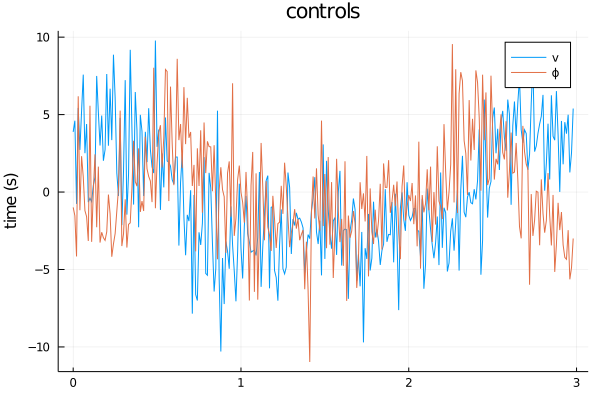

In [21]:
plot(time[1:end-1],U, labels=["v" "ϕ"], ylabel="time (s)", title="controls")

## Part (c): Monte-Carlo Analysis
We'll dig a little deeper into finding out how robust our controller is to the initial condition. Our goal is to find the largest symmetric rectangular region around the origin such that at least 95% of the samples within the region converge to the desired target state.

To do this, we'll perform a simple Monte-Carlo analysis. In this case, a deterministic sampling scheme will be more sample-efficient than random sampling. Generate a grid of uniformly-distributed sample points in only x and y, and then simulate the system from each of those initial conditions and check if the terminal error, defined as $ ||X_{ref,N} - X_N ||_2 $, is less than 0.2.

Once you have a grid of boolean values, find a $\Delta x$ and $\Delta y$ such that the area $\Delta x \Delta y$ is maximized and the at least 95% of the initial conditions within $\begin{bmatrix} \pm \Delta x & \pm \Delta y & 0 &0 \end{bmatrix}^T$ have a terminal error less than 0.2.

**HINT**: Generate a list of `(x,y,success)::Tuple{Float64,Float64,Bool}` tuples and use `filter` and `sort` to get the information you need. The `sort` method offers a `by` argument you may find useful.

In [31]:
# TASK: simulate the initial conditions for all the points in a grid of your choice
res = NTuple{3,Float64}[]   # a data structure you may find useful...

# TODO: pick a grid to sample (hint: start coarse and then refine it)
xmax = 11      # maximum x coordinate to sample
ymax = 2.5     # maximum y coordinate to sample
Nx = 101        # number of sample points in x
Ny = 51        # number of sample points in y

# Generate the ranges
xs = range(-xmax,xmax,length=Nx)
ys = range(-ymax,ymax,length=Ny)
for x in xs, y in ys
    # TODO: simulate the initial conditions and cache the terminal error 
    xinit = [x,y,0,0]
    X,U,time = simulate(model, xinit, ctrl, ν=0, w=0, dt=0.03)
    err_term = norm(X[end] - Xref[end])
    push!(res, (x,y,err_term))
end
res = hcat(collect.(res)...)  # turn the list of tuples into a 2D matrix

3×5151 Array{Float64,2}:
 -11.0     -11.0     -11.0     -11.0     …  11.0       11.0     11.0
  -2.5      -2.4      -2.3      -2.2         2.3        2.4      2.5
  14.8013   80.6647   36.4877   97.2766      0.119587  10.5582  11.9703

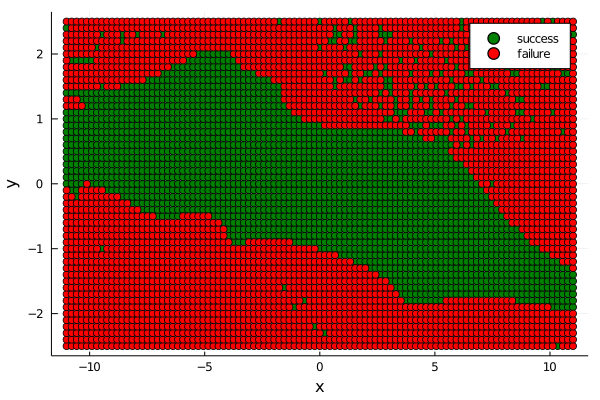

In [32]:
# Plot the initial conditions in a scatter plot
# TODO: fill the following variables to generate the plot
xpoints = res[1,:]             # (Nx*Ny,) vector of x coordinates
ypoints = res[2,:]             # (Nx*Ny,) vector of y coordinates
valid = res[3,:] .< 0.2        # (Nx*Ny,) vector of boolean values indicating success

# Generate the plot
valid = res[3,:] .< 0.2
scatter(xpoints[valid], ypoints[valid], color=:green, xlabel="x", ylabel="y", label="success")
scatter!(xpoints[.!valid],ypoints[.!valid], color=:red, label="failure")

In [38]:
# TASK: find the maximum area such that 95% of the points converge to the goal.
#       save the result in Δx and Δy
xabs = unique(abs.(xs))
yabs = unique(abs.(ys))
acc = NTuple{3,Float64}[]
for x in xabs, y in yabs
    inregion = (abs.(res[1,:]) .<= x) .& (abs.(res[2,:]) .<= y)
    num_valid = sum(inregion .& valid)
    rate = num_valid / sum(inregion)
    push!(acc, (x,y,rate))
end
max_region = sort(filter(x->x[3] >= 0.95, acc), by=x->x[1]*x[2])[end]
Δx = max_region[1]   # maximum deviation in x (half of the width of the region)
Δy = max_region[2]   # maximum deviation in y (half of the height of the region)
area = Δx * Δy
println("region: Δx = $Δx, Δy = $Δy, area = $area")

region: Δx = 5.72, Δy = 0.8, area = 4.576


In [34]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String,MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("chassis" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x6d, 0x2f, 0x63, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("body" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x73, 0x73, 0x69, 0x73, 0x2f, 0x62, 0x6f, 0x64, 0x79], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()),"wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x73, 0x69, 0x73, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))),"front" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x66, 0x72, 0x6f, 0x6e, 0x74], Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}("wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x6e, 0x74, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()))))))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [35]:
delete!(vis["ic"])
plot_region!(vis, Δx, Δy)

MeshCat Visualizer with path /meshcat/ic at http://127.0.0.1:8700

In [44]:
v = (abs.(xpoints) .<= Δx ) .& (abs.(ypoints) .<= Δy)
@test (sum(valid[v]) / sum(v)) >= 0.95

Test Passed